In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from dotenv import load_dotenv
import requests
import json
from urllib.request import urlretrieve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from ydata_profiling import ProfileReport
import pickle
import missingno as msno
from fuzzywuzzy import process

C:\Users\Brendan\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
load_dotenv()

True

*****
**Import Zillow Statistics**
*****

In [5]:
#Zillow data from .csv (pending access to API, wait time of ~10days for approval)
zillow_state_urls = {"state_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/State_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711137595"
}
zillow_zip_urls = {"zip_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711136613"
}
zillow_metro_urls = {
    "metro_hvi": "https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv?t=1711136613"
    ,"metro_rent": "https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_for_sale_inventory": "https://files.zillowstatic.com/research/public_csvs/invt_fs/Metro_invt_fs_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_new_listing": "https://files.zillowstatic.com/research/public_csvs/new_listings/Metro_new_listings_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_abv_list": "https://files.zillowstatic.com/research/public_csvs/pct_sold_above_list/Metro_pct_sold_above_list_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_blw_list": "https://files.zillowstatic.com/research/public_csvs/pct_sold_below_list/Metro_pct_sold_below_list_uc_sfrcondo_month.csv?t=1711136613"
    ,"metro_med_days_to_close": "https://files.zillowstatic.com/research/public_csvs/median_days_to_close/Metro_median_days_to_close_uc_sfrcondo_sm_month.csv?t=1711136613"
    ,"metro_pct_w_pricecut": "https://files.zillowstatic.com/research/public_csvs/perc_listings_price_cut/Metro_perc_listings_price_cut_uc_sfr_sm_month.csv?t=1711136613"
    ,"metro_new_construct": "https://files.zillowstatic.com/research/public_csvs/new_con_sales_count_raw/Metro_new_con_sales_count_raw_uc_sfr_month.csv?t=1711136613"
}

**Import: State level data**

In [6]:
#Create dictionary from state name to abbreviation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [7]:
#Import Zillow state level HVI data from .csv (pending access to API, wait time of ~10days for approval)

url = zillow_state_urls['state_hvi']
zillow_state_df = pd.read_csv(url)
zillow_state_df = zillow_state_df.drop(['SizeRank','StateName'], axis=1)
zillow_state_df['metric'] = 'state_hvi'

zillow_state_df.iloc[:,:6].head()

,RegionID,RegionName,RegionType,2000-01-31,2000-02-29,2000-03-31
0,9,California,state,197834.054631,198494.476840,199379.078116
1,54,Texas,state,113382.798809,113441.602172,113470.038472
2,14,Florida,state,113641.102281,113895.207310,114198.429813
3,43,New York,state,138372.960341,138836.093363,139286.899668
4,47,Pennsylvania,state,100063.042287,100274.348365,100475.501155


In [8]:
zillow_state_df.iloc[:,:6].describe()

,RegionID,2000-01-31,2000-02-29,2000-03-31
count,51.000000,47.000000,47.000000,47.000000
mean,33.137255,130121.175079,130333.717022,130599.288815
std,17.260382,35804.952533,35926.944539,36099.560689
min,3.000000,73417.185803,73414.145587,73438.816661
25%,19.500000,105959.014645,106140.625917,106272.777023
50%,34.000000,123776.562061,123701.207397,123747.582658
75%,46.500000,152621.901901,152908.291989,153208.997656
max,62.000000,226312.339164,226317.667925,226729.191852


In [9]:
zillow_state_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 296 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    RegionID    51 non-null     int64  
 1    RegionName  51 non-null     object 
 2    RegionType  51 non-null     object 
 3    2000-01-31  47 non-null     float64
 4    2000-02-29  47 non-null     float64
 5    2000-03-31  47 non-null     float64
 6    2000-04-30  47 non-null     float64
 7    2000-05-31  47 non-null     float64
 8    2000-06-30  47 non-null     float64
 9    2000-07-31  47 non-null     float64
 10   2000-08-31  47 non-null     float64
 11   2000-09-30  47 non-null     float64
 12   2000-10-31  47 non-null     float64
 13   2000-11-30  47 non-null     float64
 14   2000-12-31  47 non-null     float64
 15   2001-01-31  47 non-null     float64
 16   2001-02-28  47 non-null     float64
 17   2001-03-31  47 non-null     float64
 18   2001-04-30  47 non-null     float64
 19   2001-05-

In [10]:
#Add state abbreviation as 'state' column
zillow_state_df['State'] = zillow_state_df['RegionName'].map(us_state_to_abbrev)
zillow_state_df = zillow_state_df.drop(['RegionID'], axis=1)

In [11]:
#Reshape Zillow data from wide to long

zillow_state_df_long = pd.melt(zillow_state_df, id_vars=['State','RegionName','RegionType','metric'])
zillow_state_df_long["variable"] = pd.to_datetime(zillow_state_df_long["variable"])
zillow_state_df_long = zillow_state_df_long.sort_values(["variable","State"])
zillow_state_df_long = zillow_state_df_long.rename(columns={'value':'state_HVI'})
zillow_state_df_long = zillow_state_df_long.set_index('variable')

zillow_state_df_long

,State,RegionName,RegionType,metric,state_HVI
variable,,,,,
2000-01-31,AK,Alaska,state,state_hvi,134666.696277
2000-01-31,AL,Alabama,state,state_hvi,98995.203800
2000-01-31,AR,Arkansas,state,state_hvi,86953.790551
2000-01-31,AZ,Arizona,state,state_hvi,138595.252969
2000-01-31,CA,California,state,state_hvi,197834.054631
...,...,...,...,...,...
2024-04-30,VT,Vermont,state,state_hvi,395829.555876
2024-04-30,WA,Washington,state,state_hvi,611214.649176
2024-04-30,WI,Wisconsin,state,state_hvi,306459.707918


In [12]:
zillow_state_df_long.describe()

,state_HVI
count,1.466200e+04
mean,2.242794e+05
std,1.208897e+05
min,7.341415e+04
25%,1.406814e+05
50%,1.924098e+05
75%,2.654813e+05
max,1.020844e+06


In [13]:
zillow_state_df_long.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14892 entries, 2000-01-31 to 2024-04-30
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       14892 non-null  object 
 1   RegionName  14892 non-null  object 
 2   RegionType  14892 non-null  object 
 3   metric      14892 non-null  object 
 4   state_HVI   14662 non-null  float64
dtypes: float64(1), object(4)
memory usage: 698.1+ KB


<Axes: >

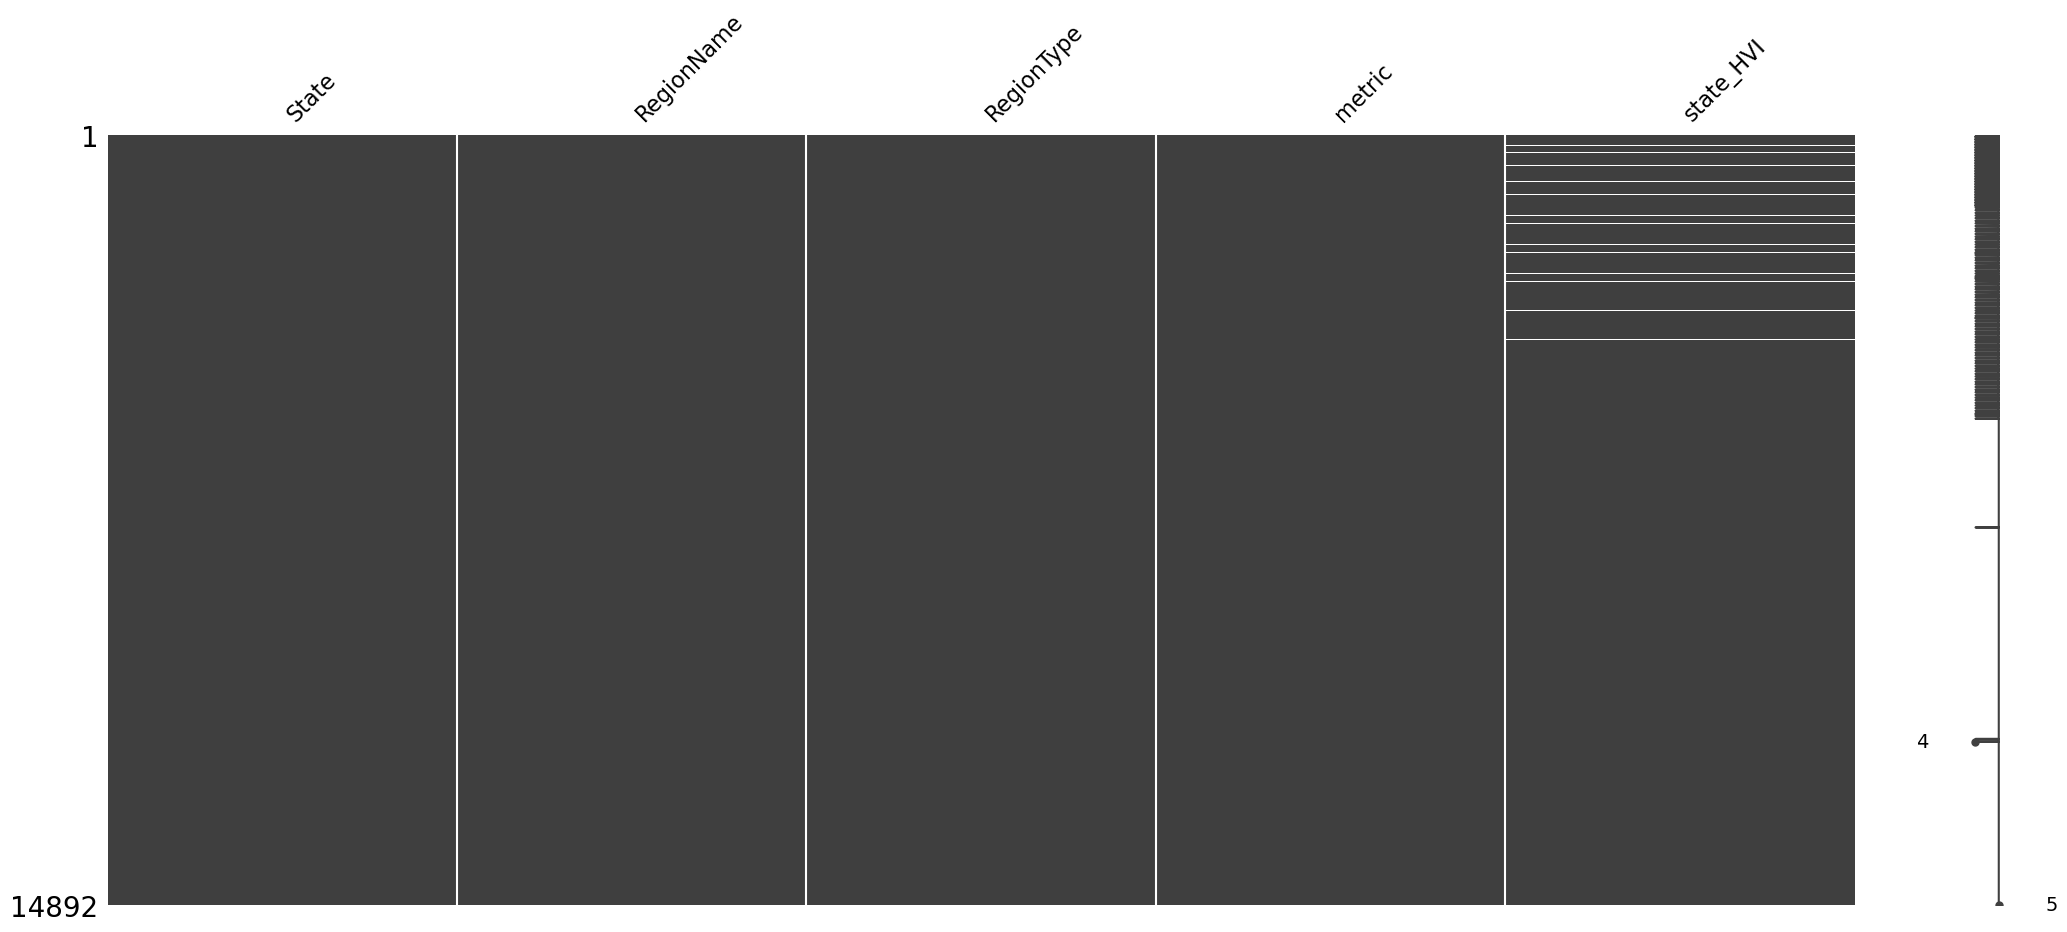

In [14]:
msno.matrix(zillow_state_df_long)

**Import: Metro level data**

In [15]:
#Import Zillow metro level data from .csv (pending access to API, wait time of ~10days for approval)

dfs = []
for metric in zillow_metro_urls:
    url = zillow_metro_urls[metric]
    df_z = pd.read_csv(url) 
    df_z['metric'] = metric
    dfs.append(df_z)

zillow_metro_df = pd.concat(dfs)

zillow_metro_df = zillow_metro_df.drop(['SizeRank'], axis=1)
zillow_metro_df.iloc[:,:5].head()

,RegionID,RegionName,RegionType,StateName,2000-01-31
0,102001,United States,country,NaN,123044.530044
1,394913,"New York, NY",msa,NY,217071.842774
2,753899,"Los Angeles, CA",msa,CA,241404.374655
3,394463,"Chicago, IL",msa,IL,158390.949567
4,394514,"Dallas, TX",msa,TX,129671.076003


In [16]:
zillow_metro_df.iloc[:,:5].describe()

,RegionID,2000-01-31
count,6287.000000,431.000000
mean,419494.797519,111105.240067
std,95764.777329,52328.756064
min,102001.000000,32416.915694
25%,394553.000000,78131.816320
50%,394802.000000,98093.783577
75%,395059.000000,127689.471154
max,845172.000000,418003.520580


In [17]:
zillow_metro_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6287 entries, 0 to 339
Data columns (total 297 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    RegionID    6287 non-null   int64  
 1    RegionName  6287 non-null   object 
 2    RegionType  6287 non-null   object 
 3    StateName   6278 non-null   object 
 4    2000-01-31  431 non-null    float64
 5    2000-02-29  432 non-null    float64
 6    2000-03-31  433 non-null    float64
 7    2000-04-30  435 non-null    float64
 8    2000-05-31  437 non-null    float64
 9    2000-06-30  438 non-null    float64
 10   2000-07-31  439 non-null    float64
 11   2000-08-31  440 non-null    float64
 12   2000-09-30  441 non-null    float64
 13   2000-10-31  441 non-null    float64
 14   2000-11-30  444 non-null    float64
 15   2000-12-31  445 non-null    float64
 16   2001-01-31  453 non-null    float64
 17   2001-02-28  453 non-null    float64
 18   2001-03-31  453 non-null    float64
 19   2001-04-30

In [18]:
#Reshape Zillow data from wide to long for dates

zillow_metro_df_long = pd.melt(zillow_metro_df, id_vars=['RegionID','RegionName','RegionType','StateName','metric'])
zillow_metro_df_long["variable"] = pd.to_datetime(zillow_metro_df_long["variable"])
zillow_metro_df_long = zillow_metro_df_long.sort_values(["RegionID","variable"])

zillow_metro_df_long

,RegionID,RegionName,RegionType,StateName,metric,variable,value
0,102001,United States,country,NaN,metro_hvi,2000-01-31,123044.530044
895,102001,United States,country,NaN,metro_rent,2000-01-31,NaN
1395,102001,United States,country,NaN,metro_for_sale_inventory,2000-01-31,NaN
2323,102001,United States,country,NaN,metro_new_listing,2000-01-31,NaN
3248,102001,United States,country,NaN,metro_pct_abv_list,2000-01-31,NaN
...,...,...,...,...,...,...,...
1826313,845172,"Winfield, KS",msa,KS,metro_new_listing,2024-03-31,25.000000
1829011,845172,"Winfield, KS",msa,KS,metro_pct_w_pricecut,2024-03-31,0.193936
1831672,845172,"Winfield, KS",msa,KS,metro_for_sale_inventory,2024-04-30,116.000000
1832600,845172,"Winfield, KS",msa,KS,metro_new_listing,2024-04-30,30.000000


In [19]:
zillow_metro_df_long.describe()

,RegionID,variable,value
count,1.835804e+06,1835804,5.527900e+05
mean,4.194948e+05,2012-03-15 18:29:35.342465536,6.982500e+04
min,1.020010e+05,2000-01-31 00:00:00,0.000000e+00
25%,3.945530e+05,2006-02-21 00:00:00,2.000000e+01
50%,3.948020e+05,2012-03-15 12:00:00,4.690000e+02
75%,3.950590e+05,2018-04-07 12:00:00,1.220569e+05
max,8.451720e+05,2024-04-30 00:00:00,1.813082e+06
std,9.575719e+04,NaN,1.176696e+05


In [20]:
zillow_metro_df_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1835804 entries, 0 to 1835298
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  object        
 2   RegionType  object        
 3   StateName   object        
 4   metric      object        
 5   variable    datetime64[ns]
 6   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 112.0+ MB


In [21]:
#Reshape Zillow data from long to wide for metrics
zillow_metro_df_metrics = zillow_metro_df_long.pivot_table(
    index=['RegionID','RegionName','RegionType','StateName','variable'],
    columns='metric',
    values='value'
)
zillow_metro_df_metrics = zillow_metro_df_metrics.reset_index()
zillow_metro_df_metrics["RegionID"] = zillow_metro_df_metrics["RegionID"].astype(str)
zillow_metro_df_metrics.sort_values(by='variable',inplace=True)
zillow_metro_df_metrics = zillow_metro_df_metrics.set_index('variable')

zillow_metro_df_metrics

metric,RegionID,RegionName,RegionType,StateName,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
variable,,,,,,,,,,,,,
2000-01-31,395007,"Pueblo, CO",msa,CO,NaN,107137.826412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394322,"Altus, OK",msa,OK,NaN,53295.286980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394476,"Clewiston, FL",msa,FL,NaN,51998.528241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,395095,"Show Low, AZ",msa,AZ,NaN,92082.656596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394911,"New Philadelphia, OH",msa,OH,NaN,111548.701327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,394569,"Emporia, KS",msa,KS,54.0,160982.277139,NaN,NaN,27.0,NaN,NaN,0.177519,1091.666667
2024-04-30,394393,"Bloomington, IN",msa,IN,458.0,302488.914076,NaN,NaN,185.0,NaN,NaN,0.166820,1841.663492
2024-04-30,394666,"Harrisburg, PA",msa,PA,862.0,284022.849764,NaN,NaN,476.0,NaN,NaN,0.180060,1820.424534


In [22]:
zillow_metro_df_metrics.describe()

metric,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
count,67406.000000,2.117880e+05,31233.000000,17597.000000,65288.000000,31191.000000,31892.000000,66948.000000,28525.000000
mean,1054.720144,1.807632e+05,34.933916,127.018355,410.706225,0.291803,0.522045,0.161407,1620.910649
std,3021.689205,1.251577e+05,7.183966,218.929666,1237.970733,0.153022,0.161320,0.053156,815.316345
min,4.000000,3.234073e+04,7.000000,5.000000,3.000000,0.000000,0.031250,0.009804,558.541829
25%,149.000000,1.086837e+05,31.000000,22.000000,43.000000,0.173180,0.407015,0.122967,1167.103697
50%,306.000000,1.452925e+05,34.000000,49.000000,92.000000,0.262004,0.529412,0.156399,1440.039464
75%,727.000000,2.077693e+05,38.000000,137.000000,251.000000,0.385998,0.640503,0.194350,1847.580625
max,71432.000000,1.813082e+06,78.000000,2488.000000,25154.000000,0.858169,1.000000,0.483076,15610.471429


In [23]:
zillow_metro_df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213384 entries, 2000-01-31 to 2024-04-30
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   RegionID                  213384 non-null  object 
 1   RegionName                213384 non-null  object 
 2   RegionType                213384 non-null  object 
 3   StateName                 213384 non-null  object 
 4   metro_for_sale_inventory  67406 non-null   float64
 5   metro_hvi                 211788 non-null  float64
 6   metro_med_days_to_close   31233 non-null   float64
 7   metro_new_construct       17597 non-null   float64
 8   metro_new_listing         65288 non-null   float64
 9   metro_pct_abv_list        31191 non-null   float64
 10  metro_pct_blw_list        31892 non-null   float64
 11  metro_pct_w_pricecut      66948 non-null   float64
 12  metro_rent                28525 non-null   float64
dtypes: float64(9), object(4)
mem

In [24]:
#confirm all metros are in only 1 state
temp = pd.DataFrame(zillow_metro_df_metrics.RegionName.unique())
temp[[0,1]] = temp[0].str.split(',', expand=True)
temp = temp.sort_values(by=1)
temp[1].unique()

array([' AK', ' AL', ' AR', ' AZ', ' CA', ' CO', ' CT', ' DC', ' DE',
       ' FL', ' GA', ' HI', ' IA', ' ID', ' IL', ' IN', ' KS', ' KY',
       ' LA', ' MA', ' MD', ' ME', ' MI', ' MN', ' MO', ' MS', ' MT',
       ' NC', ' ND', ' NE', ' NH', ' NJ', ' NM', ' NV', ' NY', ' OH',
       ' OK', ' OR', ' PA', ' RI', ' SC', ' SD', ' TN', ' TX', ' UT',
       ' VA', ' VT', ' WA', ' WI', ' WV', ' WY'], dtype=object)

<Axes: >

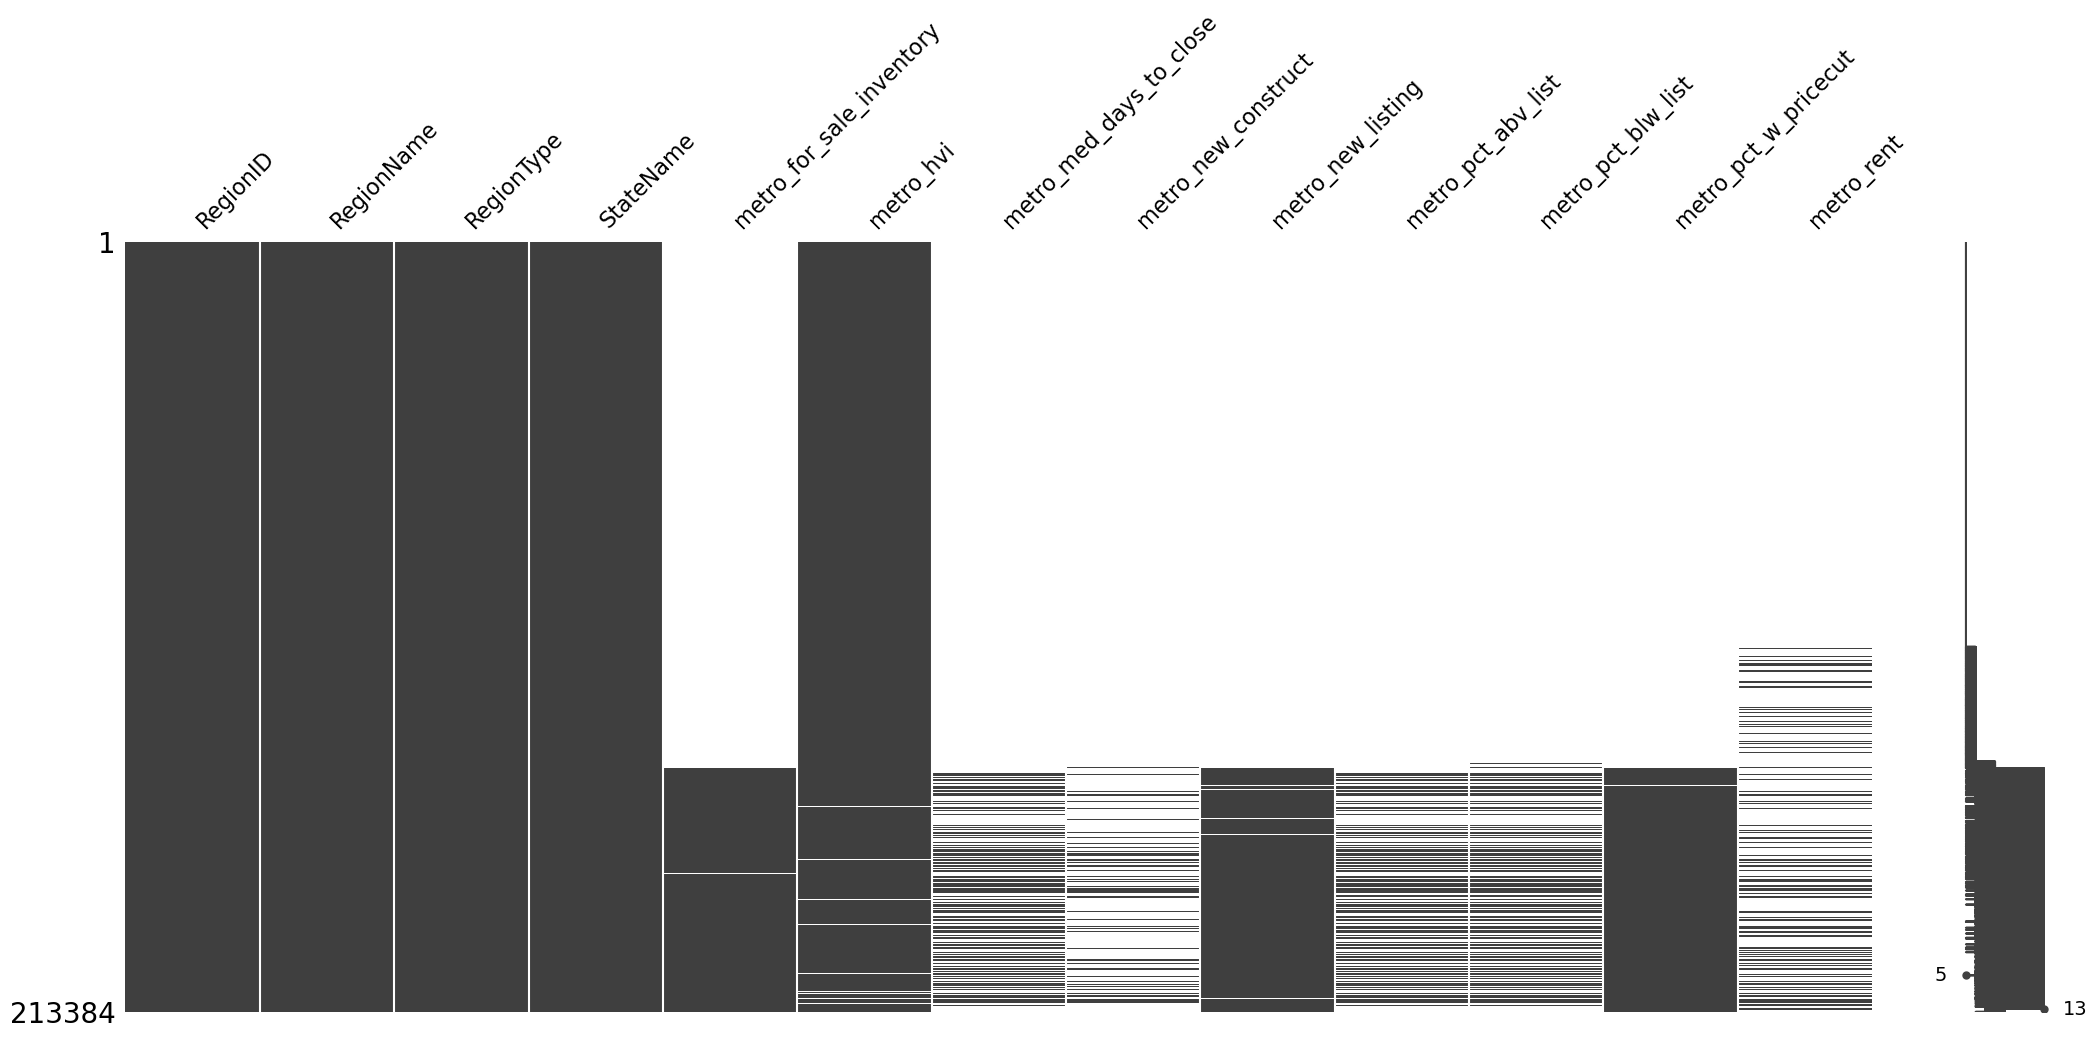

In [25]:
msno.matrix(zillow_metro_df_metrics)

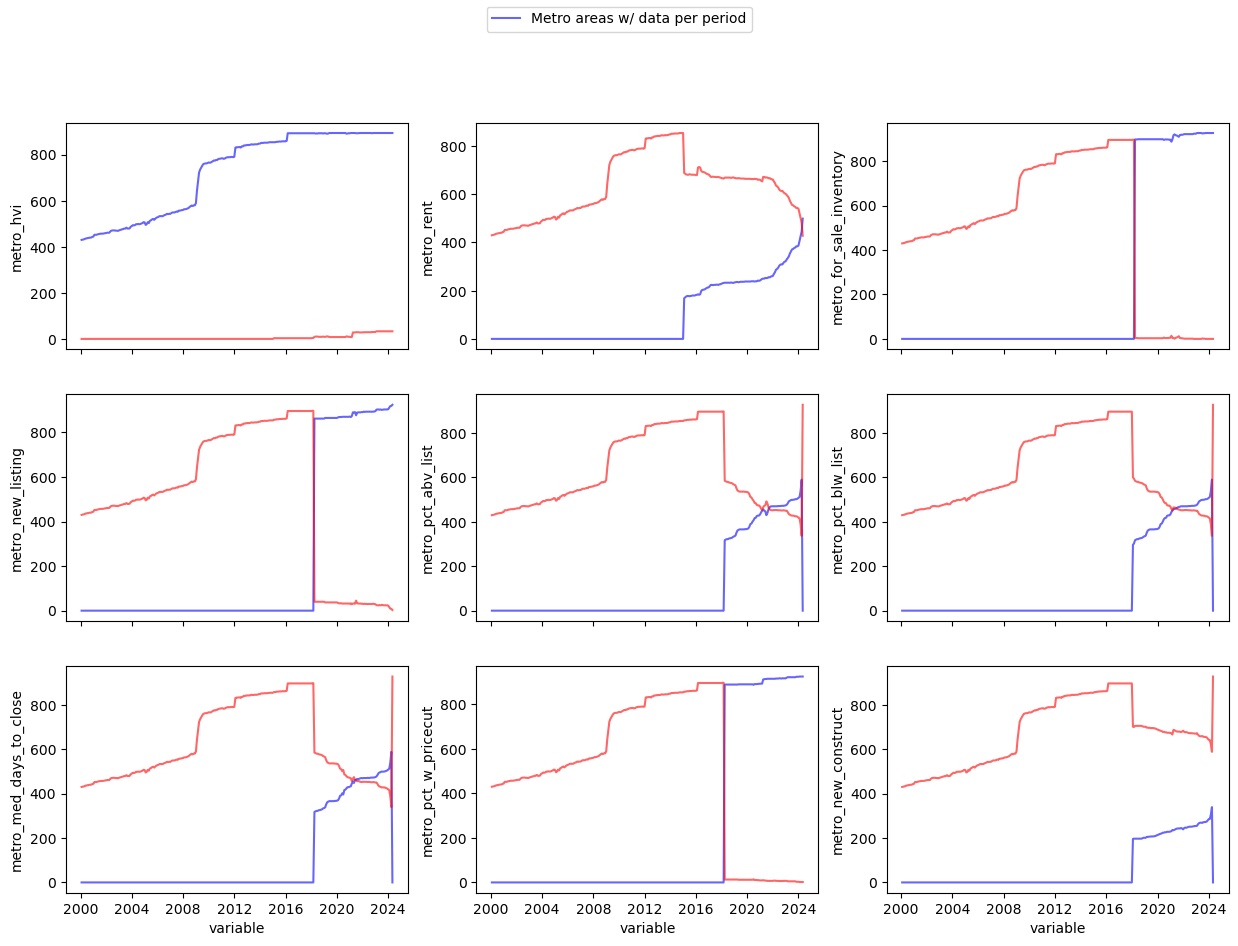

In [26]:
val_count = zillow_metro_df_metrics.groupby('variable').count()
na_count = zillow_metro_df_metrics.groupby('variable').apply(lambda x: x.isnull().sum())

fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for i, metric in enumerate(zillow_metro_urls):

    ax_loc = ax[(i // 3) % 3, i % 3]
    
    sns.lineplot(data=val_count, x=val_count.index, y=metric, ax=ax_loc, color='blue', alpha=.6)
    sns.lineplot(data=na_count, x=na_count.index, y=metric, ax=ax_loc, color='red', alpha=.6)

#plt.legend()
plt.figlegend(['Metro areas w/ data per period'], loc='upper center', ncol=3)
plt.show()

**Import: Zip code level data**

In [27]:
#Import Zillow zipcode level data from .csv (pending access to API, wait time of ~10days for approval)

dfs = []
for metric in zillow_zip_urls:
    url = zillow_zip_urls[metric]
    df_z = pd.read_csv(url) 
    df_z['metric'] = metric
    dfs.append(df_z)

zillow_zip_df = pd.concat(dfs)

zillow_zip_df['RegionName'] = zillow_zip_df['RegionName'].astype(str).str.zfill(5)
zillow_zip_df = zillow_zip_df.drop(['SizeRank','StateName'], axis=1)

zillow_zip_df.iloc[:,:8].head()

,RegionID,RegionName,RegionType,State,City,Metro,CountyName,2000-01-31
0,91982,77494,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,213988.894656
1,61148,08701,zip,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,166377.755183
2,91940,77449,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,104721.972273
3,62080,11368,zip,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,303435.140966
4,91733,77084,zip,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,103839.385558


In [28]:
zillow_zip_df.iloc[:,:8].describe()

,RegionID,2000-01-31
count,26238.000000,1.277200e+04
mean,80494.160340,1.515681e+05
std,28266.183629,1.148904e+05
min,58196.000000,3.668912e+03
25%,68892.250000,8.363847e+04
50%,78830.500000,1.228160e+05
75%,88639.500000,1.824908e+05
max,808739.000000,2.118798e+06


In [29]:
zillow_zip_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26238 entries, 0 to 26237
Data columns (total 300 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    RegionID    26238 non-null  int64  
 1    RegionName  26238 non-null  object 
 2    RegionType  26238 non-null  object 
 3    State       26238 non-null  object 
 4    City        25156 non-null  object 
 5    Metro       20545 non-null  object 
 6    CountyName  26238 non-null  object 
 7    2000-01-31  12772 non-null  float64
 8    2000-02-29  12835 non-null  float64
 9    2000-03-31  12850 non-null  float64
 10   2000-04-30  12869 non-null  float64
 11   2000-05-31  12934 non-null  float64
 12   2000-06-30  12947 non-null  float64
 13   2000-07-31  12963 non-null  float64
 14   2000-08-31  12988 non-null  float64
 15   2000-09-30  13002 non-null  float64
 16   2000-10-31  13015 non-null  float64
 17   2000-11-30  13037 non-null  float64
 18   2000-12-31  13052 non-null  float64
 19   20

In [30]:
#Reshape Zillow data from wide to long

zillow_zip_df_long = pd.melt(zillow_zip_df, id_vars=['RegionID','RegionName','RegionType','State','City','Metro','CountyName','metric'])
zillow_zip_df_long["variable"] = pd.to_datetime(zillow_zip_df_long["variable"])
zillow_zip_df_long = zillow_zip_df_long.sort_values(["RegionID","variable"])

zillow_zip_df_long

,RegionID,RegionName,RegionType,State,City,Metro,CountyName,metric,variable,value
7343,58196,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,zip_hvi,2000-01-31,132607.745108
33581,58196,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,zip_hvi,2000-02-29,132459.217610
59819,58196,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,zip_hvi,2000-03-31,132463.000356
86057,58196,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,zip_hvi,2000-04-30,132588.423552
112295,58196,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,zip_hvi,2000-05-31,133375.342203
...,...,...,...,...,...,...,...,...,...,...
7543194,808739,87547,zip,NM,Los Alamos,"Los Alamos, NM",Los Alamos County,zip_hvi,2023-12-31,545305.721309
7569432,808739,87547,zip,NM,Los Alamos,"Los Alamos, NM",Los Alamos County,zip_hvi,2024-01-31,550735.305991
7595670,808739,87547,zip,NM,Los Alamos,"Los Alamos, NM",Los Alamos County,zip_hvi,2024-02-29,556704.009496
7621908,808739,87547,zip,NM,Los Alamos,"Los Alamos, NM",Los Alamos County,zip_hvi,2024-03-31,562518.225507


In [31]:
zillow_zip_df_long.describe()

,RegionID,variable,value
count,7.661496e+06,7661496,5.717389e+06
mean,8.049416e+04,2012-03-15 18:29:35.342462720,2.433358e+05
min,5.819600e+04,2000-01-31 00:00:00,3.628869e+03
25%,6.889200e+04,2006-02-21 00:00:00,1.156271e+05
50%,7.883050e+04,2012-03-15 12:00:00,1.737892e+05
75%,8.864000e+04,2018-04-07 12:00:00,2.804219e+05
max,8.087390e+05,2024-04-30 00:00:00,1.261375e+07
std,2.826565e+04,NaN,2.523651e+05


In [32]:
zillow_zip_df_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7661496 entries, 7343 to 7648146
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  object        
 2   RegionType  object        
 3   State       object        
 4   City        object        
 5   Metro       object        
 6   CountyName  object        
 7   metric      object        
 8   variable    datetime64[ns]
 9   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 643.0+ MB


In [33]:
counts = zillow_zip_df_long.groupby('RegionName')['RegionID'].nunique()
print(counts.sort_values(ascending=False))

RegionName
01001    1
61937    1
62002    1
62001    1
61957    1
        ..
32759    1
32757    1
32754    1
32751    1
99929    1
Name: RegionID, Length: 26238, dtype: int64


In [34]:
#Reshape Zillow data from long to wide for metrics
zillow_zip_df_metrics = zillow_zip_df_long.pivot_table(
    index=['RegionName','RegionType','State','City','Metro','CountyName','variable'],
    columns='metric',
    values='value'
)
zillow_zip_df_metrics = zillow_zip_df_metrics.reset_index()
zillow_zip_df_metrics.sort_values(by='variable',inplace=True)
zillow_zip_df_metrics = zillow_zip_df_metrics.set_index('variable')

zillow_zip_df_metrics

metric,RegionName,RegionType,State,City,Metro,CountyName,zip_hvi
variable,,,,,,,
2000-01-31,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,132607.745108
2000-01-31,66610,zip,KS,Topeka,"Topeka, KS",Shawnee County,173764.433284
2000-01-31,08053,zip,NJ,Evesham Township,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Burlington County,161170.947006
2000-01-31,66611,zip,KS,Topeka,"Topeka, KS",Shawnee County,69906.010574
2000-01-31,66614,zip,KS,Topeka,"Topeka, KS",Shawnee County,104126.974085
...,...,...,...,...,...,...,...
2024-04-30,96760,zip,HI,Kurtistown,"Hilo, HI",Hawaii County,372157.729413
2024-04-30,40517,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,237579.657067
2024-04-30,40516,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,293417.918043


In [35]:
zillow_zip_df_metrics.describe()

metric,zip_hvi
count,4.744247e+06
mean,2.607811e+05
std,2.668173e+05
min,3.628869e+03
25%,1.234272e+05
50%,1.868332e+05
75%,3.030818e+05
max,1.261375e+07


In [36]:
zillow_zip_df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4744247 entries, 2000-01-31 to 2024-04-30
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionName  object 
 1   RegionType  object 
 2   State       object 
 3   City        object 
 4   Metro       object 
 5   CountyName  object 
 6   zip_hvi     float64
dtypes: float64(1), object(6)
memory usage: 289.6+ MB


<Axes: >

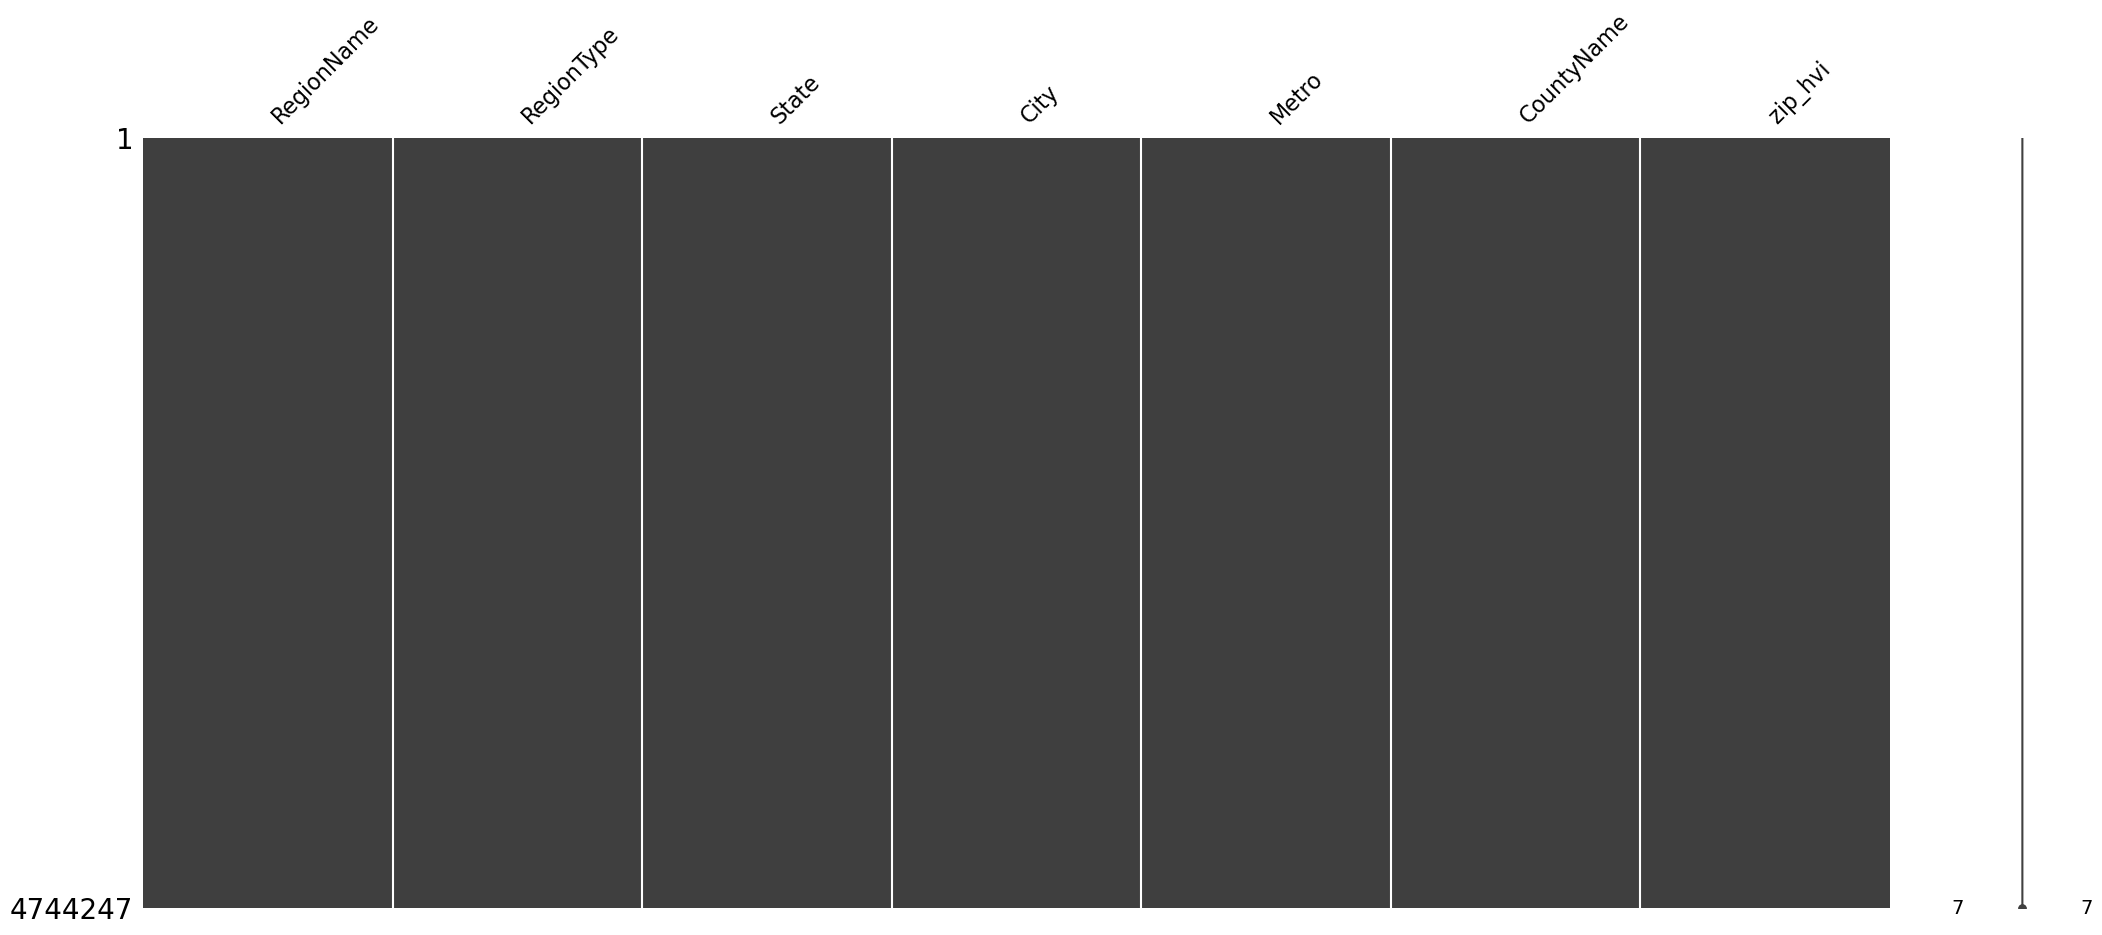

In [37]:
msno.matrix(zillow_zip_df_metrics)

*****
**Profile Datasets**
*****

In [38]:
zillow_zip_df_metrics

metric,RegionName,RegionType,State,City,Metro,CountyName,zip_hvi
variable,,,,,,,
2000-01-31,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,132607.745108
2000-01-31,66610,zip,KS,Topeka,"Topeka, KS",Shawnee County,173764.433284
2000-01-31,08053,zip,NJ,Evesham Township,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Burlington County,161170.947006
2000-01-31,66611,zip,KS,Topeka,"Topeka, KS",Shawnee County,69906.010574
2000-01-31,66614,zip,KS,Topeka,"Topeka, KS",Shawnee County,104126.974085
...,...,...,...,...,...,...,...
2024-04-30,96760,zip,HI,Kurtistown,"Hilo, HI",Hawaii County,372157.729413
2024-04-30,40517,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,237579.657067
2024-04-30,40516,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,293417.918043


In [39]:
zillow_metro_df_metrics

metric,RegionID,RegionName,RegionType,StateName,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
variable,,,,,,,,,,,,,
2000-01-31,395007,"Pueblo, CO",msa,CO,NaN,107137.826412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394322,"Altus, OK",msa,OK,NaN,53295.286980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394476,"Clewiston, FL",msa,FL,NaN,51998.528241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,395095,"Show Low, AZ",msa,AZ,NaN,92082.656596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,394911,"New Philadelphia, OH",msa,OH,NaN,111548.701327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,394569,"Emporia, KS",msa,KS,54.0,160982.277139,NaN,NaN,27.0,NaN,NaN,0.177519,1091.666667
2024-04-30,394393,"Bloomington, IN",msa,IN,458.0,302488.914076,NaN,NaN,185.0,NaN,NaN,0.166820,1841.663492
2024-04-30,394666,"Harrisburg, PA",msa,PA,862.0,284022.849764,NaN,NaN,476.0,NaN,NaN,0.180060,1820.424534


In [40]:
#Confirm all dates are end of month
list(zillow_metro_df_metrics.index.unique())

[Timestamp('2000-01-31 00:00:00'),
 Timestamp('2000-02-29 00:00:00'),
 Timestamp('2000-03-31 00:00:00'),
 Timestamp('2000-04-30 00:00:00'),
 Timestamp('2000-05-31 00:00:00'),
 Timestamp('2000-06-30 00:00:00'),
 Timestamp('2000-07-31 00:00:00'),
 Timestamp('2000-08-31 00:00:00'),
 Timestamp('2000-09-30 00:00:00'),
 Timestamp('2000-10-31 00:00:00'),
 Timestamp('2000-11-30 00:00:00'),
 Timestamp('2000-12-31 00:00:00'),
 Timestamp('2001-01-31 00:00:00'),
 Timestamp('2001-02-28 00:00:00'),
 Timestamp('2001-03-31 00:00:00'),
 Timestamp('2001-04-30 00:00:00'),
 Timestamp('2001-05-31 00:00:00'),
 Timestamp('2001-06-30 00:00:00'),
 Timestamp('2001-07-31 00:00:00'),
 Timestamp('2001-08-31 00:00:00'),
 Timestamp('2001-09-30 00:00:00'),
 Timestamp('2001-10-31 00:00:00'),
 Timestamp('2001-11-30 00:00:00'),
 Timestamp('2001-12-31 00:00:00'),
 Timestamp('2002-01-31 00:00:00'),
 Timestamp('2002-02-28 00:00:00'),
 Timestamp('2002-03-31 00:00:00'),
 Timestamp('2002-04-30 00:00:00'),
 Timestamp('2002-05-

In [41]:
zillow_state_df_metrics = zillow_state_df_long.drop(columns='metric')
zillow_state_df_metrics

,State,RegionName,RegionType,state_HVI
variable,,,,
2000-01-31,AK,Alaska,state,134666.696277
2000-01-31,AL,Alabama,state,98995.203800
2000-01-31,AR,Arkansas,state,86953.790551
2000-01-31,AZ,Arizona,state,138595.252969
2000-01-31,CA,California,state,197834.054631
...,...,...,...,...
2024-04-30,VT,Vermont,state,395829.555876
2024-04-30,WA,Washington,state,611214.649176
2024-04-30,WI,Wisconsin,state,306459.707918


In [42]:
#last period with no data
review = zillow_state_df_metrics[zillow_state_df_metrics['state_HVI'].isnull()]
print(review.index.max())

2019-03-31 00:00:00


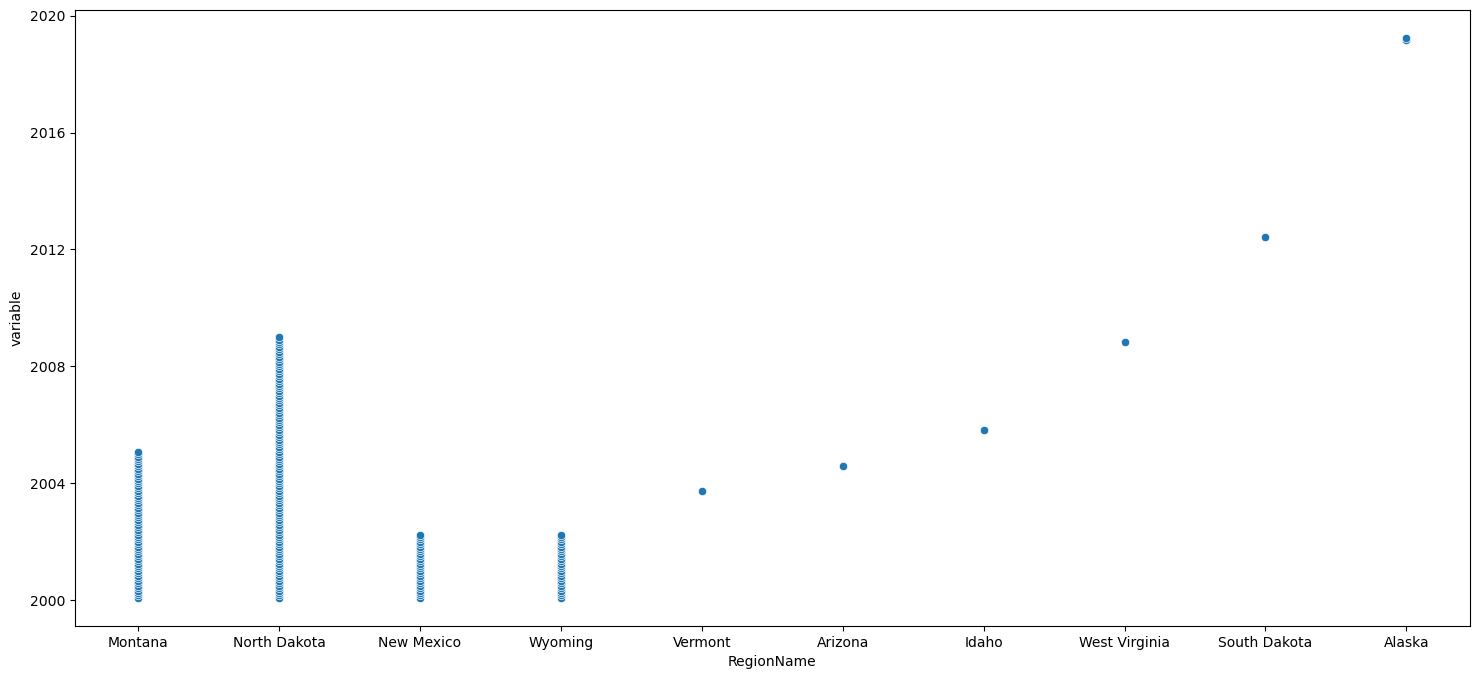

In [43]:
#sporadic missing values identified. Will keep these records.
plt.figure(figsize=(18,8))
sns.scatterplot(x="RegionName", y="variable", data=review)
plt.show()

In [44]:
#Cache premerged datasets
zillow_zip_df_metrics.to_pickle('../Data/zillow_zip_cache.pkl')
zillow_metro_df_metrics.to_pickle('../Data/zillow_metro_cache.pkl')
zillow_state_df_metrics.to_pickle('../Data/zillow_state_cache.pkl')

**Merge datasets**

**Merge state data to metro**

In [45]:
#Add state metrics to metro dataset
zillow_metro_state = pd.merge(zillow_metro_df_metrics,zillow_state_df_metrics,left_on=['StateName','variable'],right_on=['State','variable'],how='left')

In [46]:
print("original metro record count:",len(zillow_metro_df_metrics))
print("original state record count:",len(zillow_state_df_metrics))
print("Zip record still same after left join?:",len(zillow_metro_df_metrics) == len(zillow_metro_state))
zillow_metro_state.head(5)

original metro record count: 213384
original state record count: 14892
Zip record still same after left join?: True


,RegionID,RegionName_x,RegionType_x,StateName,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent,State,RegionName_y,RegionType_y,state_HVI
variable,,,,,,,,,,,,,,,,,
2000-01-31,395007,"Pueblo, CO",msa,CO,NaN,107137.826412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CO,Colorado,state,183390.768435
2000-01-31,394322,"Altus, OK",msa,OK,NaN,53295.286980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,Oklahoma,state,82887.526451
2000-01-31,394476,"Clewiston, FL",msa,FL,NaN,51998.528241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,Florida,state,113641.102281
2000-01-31,395095,"Show Low, AZ",msa,AZ,NaN,92082.656596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AZ,Arizona,state,138595.252969
2000-01-31,394911,"New Philadelphia, OH",msa,OH,NaN,111548.701327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OH,Ohio,state,107115.766298


In [47]:
zillow_metro_state_clean = zillow_metro_state.rename(columns={
    "RegionID":"metro_ID",
    "RegionName_x":"metro_name",
    "RegionType_x":"metro_type",
    "StateName":"state_ID",
    "RegionName_y":"state_name",
    "RegionType_y":"state_type",
})

zillow_metro_state_clean.sort_values(by=['variable','state_ID','metro_ID'], inplace=True)
zillow_metro_state_clean

,metro_ID,metro_name,metro_type,state_ID,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent,State,state_name,state_type,state_HVI
variable,,,,,,,,,,,,,,,,,
2000-01-31,394327,"Anchorage, AK",msa,AK,NaN,1.387595e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AK,Alaska,state,134666.696277
2000-01-31,394351,"Auburn, AL",msa,AL,NaN,1.330482e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,Alabama,state,98995.203800
2000-01-31,394388,"Birmingham, AL",msa,AL,NaN,1.127841e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,Alabama,state,98995.203800
2000-01-31,394519,"Daphne, AL",msa,AL,NaN,1.196219e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,Alabama,state,98995.203800
2000-01-31,394870,"Mobile, AL",msa,AL,NaN,8.949062e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,Alabama,state,98995.203800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,394713,"Jackson, WY",msa,WY,245.0,1.640765e+06,NaN,NaN,75.0,NaN,NaN,0.068266,NaN,WY,Wyoming,state,343331.284882
2024-04-30,394771,"Laramie, WY",msa,WY,71.0,3.609566e+05,NaN,NaN,36.0,NaN,NaN,0.072989,1694.206349,WY,Wyoming,state,343331.284882
2024-04-30,395026,"Riverton, WY",msa,WY,182.0,3.131453e+05,NaN,NaN,38.0,NaN,NaN,0.088527,1237.500000,WY,Wyoming,state,343331.284882


**Merge state and metro data to zip**

In [48]:
#Add state metrics to zip dataset
zillow_zip_state = pd.merge(zillow_zip_df_metrics,zillow_state_df_metrics,on=['State','variable'],how='left')

In [49]:
print("original zip record count:",len(zillow_zip_df_metrics))
print("original state record count:",len(zillow_state_df_metrics))
print("Zip record still same after left join?:",len(zillow_zip_df_metrics) == len(zillow_zip_state))
zillow_zip_state

original zip record count: 4744247
original state record count: 14892
Zip record still same after left join?: True


,RegionName_x,RegionType_x,State,City,Metro,CountyName,zip_hvi,RegionName_y,RegionType_y,state_HVI
variable,,,,,,,,,,
2000-01-31,01001,zip,MA,Agawam,"Springfield, MA",Hampden County,132607.745108,Massachusetts,state,203982.925310
2000-01-31,66610,zip,KS,Topeka,"Topeka, KS",Shawnee County,173764.433284,Kansas,state,89871.809215
2000-01-31,08053,zip,NJ,Evesham Township,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Burlington County,161170.947006,New Jersey,state,175374.659828
2000-01-31,66611,zip,KS,Topeka,"Topeka, KS",Shawnee County,69906.010574,Kansas,state,89871.809215
2000-01-31,66614,zip,KS,Topeka,"Topeka, KS",Shawnee County,104126.974085,Kansas,state,89871.809215
...,...,...,...,...,...,...,...,...,...,...
2024-04-30,96760,zip,HI,Kurtistown,"Hilo, HI",Hawaii County,372157.729413,Hawaii,state,996981.526971
2024-04-30,40517,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,237579.657067,Kentucky,state,207527.010794
2024-04-30,40516,zip,KY,Lexington,"Lexington-Fayette, KY",Fayette County,293417.918043,Kentucky,state,207527.010794


In [50]:
zillow_zip_state_clean = zillow_zip_state.rename(columns={
    "RegionName_x":"zip_ID",
    "RegionType_x":"zip_type",
    "State":"state_ID",
    "RegionName_y":"state_name",
    "RegionType_y":"state_type",
})

zillow_zip_state_clean.sort_values(by=['variable','state_ID','zip_ID'], inplace=True)
zillow_zip_state_clean

,zip_ID,zip_type,state_ID,City,Metro,CountyName,zip_hvi,state_name,state_type,state_HVI
variable,,,,,,,,,,
2000-01-31,99501,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.461528e+05,Alaska,state,134666.696277
2000-01-31,99502,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.477658e+05,Alaska,state,134666.696277
2000-01-31,99503,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.180325e+05,Alaska,state,134666.696277
2000-01-31,99504,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.285715e+05,Alaska,state,134666.696277
2000-01-31,99507,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.499533e+05,Alaska,state,134666.696277
...,...,...,...,...,...,...,...,...,...,...
2024-04-30,82945,zip,WY,Superior,"Rock Springs, WY",Sweetwater County,7.999206e+04,Wyoming,state,343331.284882
2024-04-30,83001,zip,WY,Jackson,"Jackson, WY-ID",Teton County,2.436553e+06,Wyoming,state,343331.284882
2024-04-30,83013,zip,WY,Moran,"Jackson, WY-ID",Teton County,1.615266e+06,Wyoming,state,343331.284882


<Axes: >

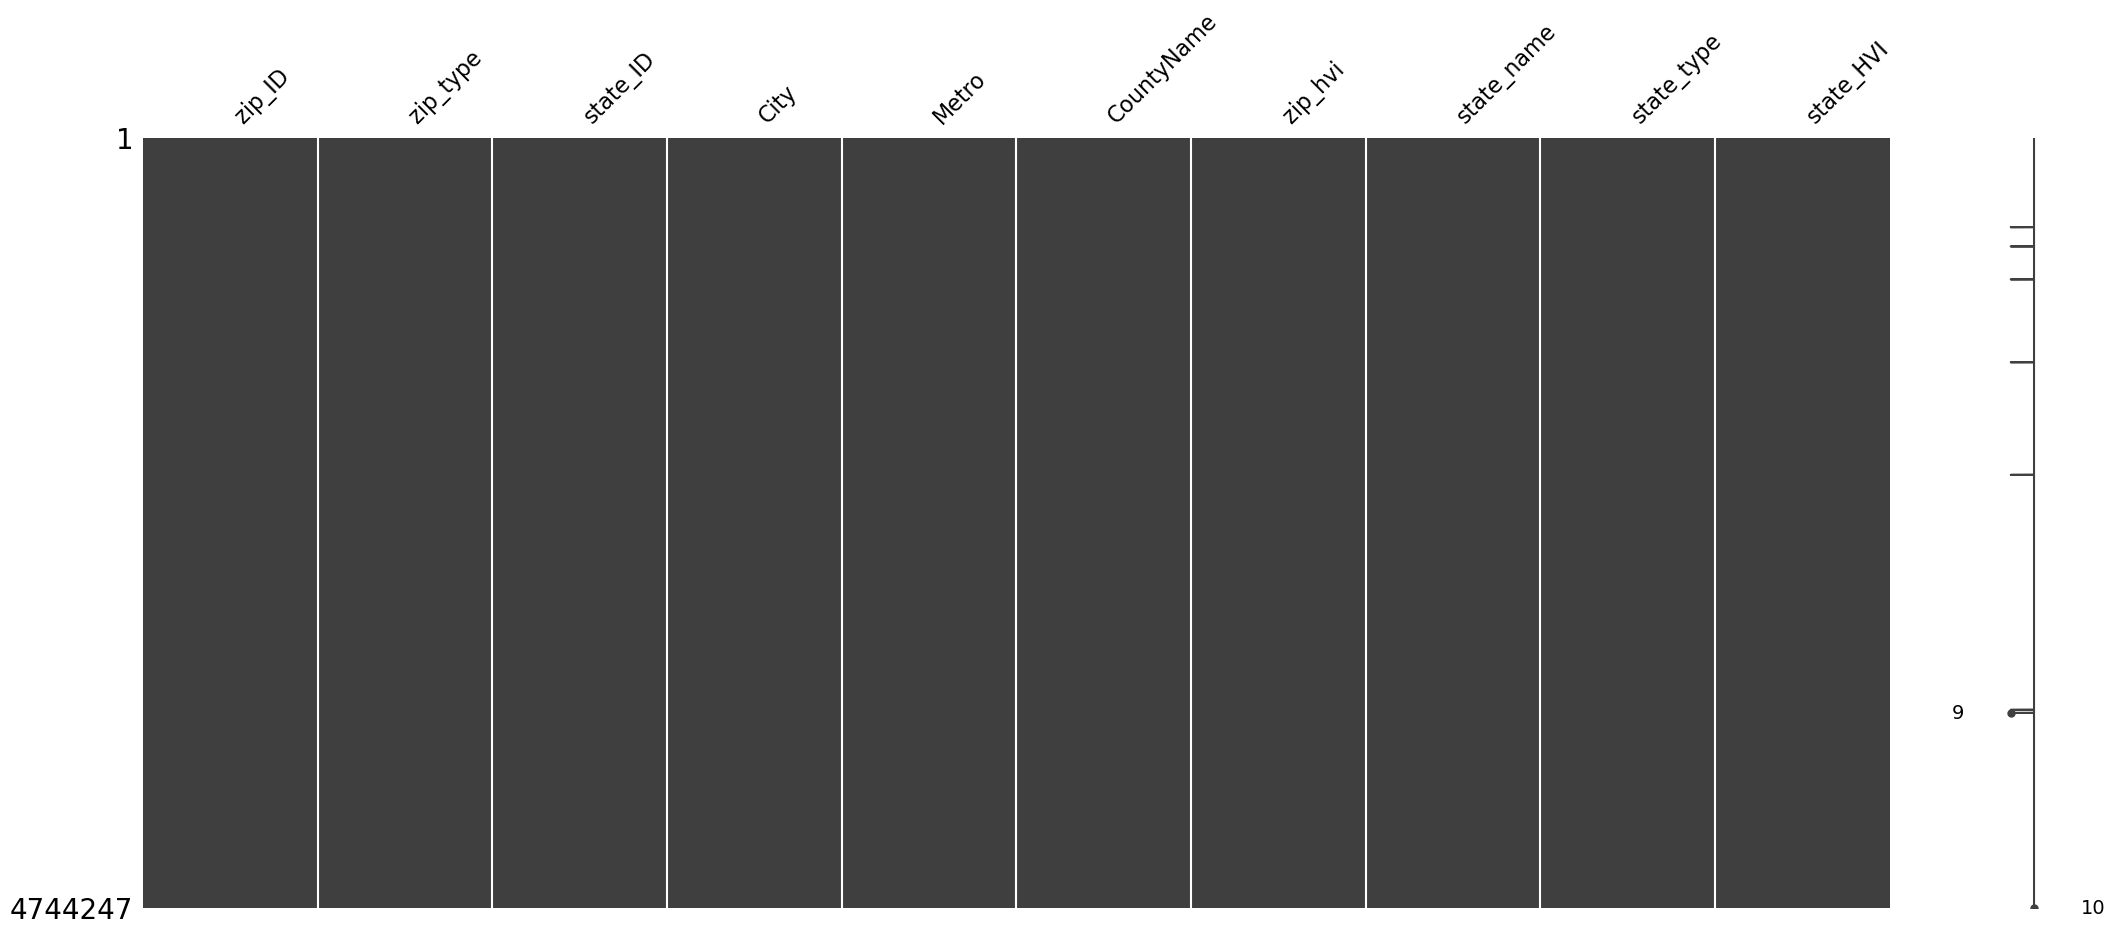

In [51]:
#review missing values
msno.matrix(zillow_zip_state_clean)

In [52]:
#Add combined state/zip metrics to metro dataset
zillow_metro_state_zip = pd.merge(zillow_zip_state_clean,zillow_metro_df_metrics,left_on=['Metro','variable'],right_on=['RegionName','variable'],how='left')

In [53]:
print("original zip record count:",len(zillow_zip_df_metrics))
print("original metro record count:",len(zillow_metro_df_metrics))
print("Zip record still same after left join?:",len(zillow_zip_df_metrics) == len(zillow_metro_state_zip))
zillow_metro_state_zip

original zip record count: 4744247
original metro record count: 213384
Zip record still same after left join?: True


,zip_ID,zip_type,state_ID,City,Metro,CountyName,zip_hvi,state_name,state_type,state_HVI,...,StateName,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,metro_new_construct,metro_new_listing,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent
variable,,,,,,,,,,,,,,,,,,,,,
2000-01-31,99501,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.461528e+05,Alaska,state,134666.696277,...,AK,NaN,138759.480842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,99502,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.477658e+05,Alaska,state,134666.696277,...,AK,NaN,138759.480842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,99503,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.180325e+05,Alaska,state,134666.696277,...,AK,NaN,138759.480842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,99504,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.285715e+05,Alaska,state,134666.696277,...,AK,NaN,138759.480842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,99507,zip,AK,Anchorage,"Anchorage, AK",Anchorage Borough,1.499533e+05,Alaska,state,134666.696277,...,AK,NaN,138759.480842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,82945,zip,WY,Superior,"Rock Springs, WY",Sweetwater County,7.999206e+04,Wyoming,state,343331.284882,...,WY,109.0,274307.811306,NaN,NaN,39.0,NaN,NaN,0.151985,NaN
2024-04-30,83001,zip,WY,Jackson,"Jackson, WY-ID",Teton County,2.436553e+06,Wyoming,state,343331.284882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30,83013,zip,WY,Moran,"Jackson, WY-ID",Teton County,1.615266e+06,Wyoming,state,343331.284882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
zillow_metro_state_zip_temp = zillow_metro_state_zip.drop(columns=['StateName', 'RegionName'])
zillow_metro_state_zip_clean = zillow_metro_state_zip_temp.rename(columns={
    "Metro":"metro_name",
    "RegionID":"metro_ID",
    "RegionType":"metro_type"
})
zillow_metro_state_zip_clean.sort_values(by=['variable','state_ID','metro_name','zip_ID'], inplace=True)
zillow_metro_state_zip_clean = zillow_metro_state_zip_clean[[
    'zip_ID', 'zip_type', 'state_ID', 'state_name', 'state_type', 'metro_ID', 'metro_name', 'metro_type', 
    'zip_hvi', 'state_HVI', 'metro_hvi',
    'metro_new_construct', 'metro_new_listing', 'metro_for_sale_inventory', 'metro_rent', 
    'metro_med_days_to_close', 'metro_pct_abv_list', 'metro_pct_blw_list', 'metro_pct_w_pricecut'
]]
zillow_metro_state_zip_clean = zillow_metro_state_zip_clean.set_index([zillow_metro_state_zip_clean.index,'zip_ID'])
zillow_metro_state_zip_clean

zip_type state_ID state_name state_type metro_ID  \
variable   zip_ID                                                    
2000-01-31 99501       zip       AK     Alaska      state   394327   
           99502       zip       AK     Alaska      state   394327   
           99503       zip       AK     Alaska      state   394327   
           99504       zip       AK     Alaska      state   394327   
           99507       zip       AK     Alaska      state   394327   
...                    ...      ...        ...        ...      ...   
2024-04-30 82835       zip       WY    Wyoming      state   395093   
           82836       zip       WY    Wyoming      state   395093   
           82838       zip       WY    Wyoming      state   395093   
           82839       zip       WY    Wyoming      state   395093   
           82842       zip       WY    Wyoming      state   395093   

                      metro_name metro_type        zip_hvi      state_HVI  \
variable   zip_ID                                                           
2000-01-31 99501   Anchorage, AK        msa  146152.791083  134666.696277   
           99502   Anchorage, AK        msa  147765.849650  134666.696277   
           99503   Anchorage, AK        msa  118032.517203  134666.696277   
           99504   Anchorage, AK        msa  128571.496217  134666.696277   
           99507   Anchorage, AK        msa  149953.309096  134666.696277   
...                          ...        ...            ...            ...   
2024-04-30 82835    Sheridan, WY        msa  518033.305770  343331.284882   
           82836    Sheridan, WY        msa  442368.866708  343331.284882   
           82838    Sheridan, WY        msa  541060.680101  343331.284882   
           82839    Sheridan, WY        msa  401414.699896  343331.284882   
           82842    Sheridan, WY        msa  445708.827370  343331.284882   

                       metro_hvi  metro_new_construct  metro_new_listing  \
variable   zip_ID                                                          
2000-01-31 99501   138759.480842                  NaN                NaN   
           99502   138759.480842                  NaN                NaN   
           99503   138759.480842                  NaN                NaN   
           99504   138759.480842                  NaN                NaN   
           99507   138759.480842                  NaN                NaN   
...                          ...                  ...                ...   
2024-04-30 82835   418881.698122                  NaN               37.0   
           82836   418881.698122                  NaN               37.0   
           82838   418881.698122                  NaN               37.0   
           82839   418881.698122                  NaN               37.0   
           82842   418881.698122                  NaN               37.0   

                   metro_for_sale_inventory  metro_rent  \
variable   zip_ID                                         
2000-01-31 99501                        NaN         NaN   
           99502                        NaN         NaN   
           99503                        NaN         NaN   
           99504                        NaN         NaN   
           99507                        NaN         NaN   
...                                     ...         ...   
2024-04-30 82835                      167.0         NaN   
           82836                      167.0         NaN   
           82838                      167.0         NaN   
           82839                      167.0         NaN   
           82842                      167.0         NaN   

                   metro_med_days_to_close  metro_pct_abv_list  \
variable   zip_ID                                                
2000-01-31 99501                       NaN                 NaN   
           99502                       NaN                 NaN   
           99503                       NaN                 NaN   
           99504  

In [55]:
zillow_metro_state_zip_clean.describe()

,zip_hvi,state_HVI,metro_hvi,metro_new_construct,metro_new_listing,metro_for_sale_inventory,metro_rent,metro_med_days_to_close,metro_pct_abv_list,metro_pct_blw_list,metro_pct_w_pricecut
count,4.744247e+06,4.743691e+06,1.826729e+06,221763.000000,609880.000000,614528.000000,380205.000000,367004.000000,367163.000000,375630.000000,613933.000000
mean,2.607811e+05,2.330286e+05,1.797560e+05,89.189400,430.135204,1187.149053,1426.707176,36.046765,0.307069,0.510947,0.168499
std,2.668173e+05,1.215550e+05,1.062141e+05,106.073911,631.100390,1708.148256,466.213422,7.902303,0.152495,0.157688,0.053091
min,3.628869e+03,7.341415e+04,3.234073e+04,5.000000,3.000000,4.000000,558.541829,7.000000,0.000000,0.060000,0.009804
25%,1.234272e+05,1.467277e+05,1.157571e+05,24.000000,66.000000,230.000000,1117.508018,31.000000,0.188642,0.399513,0.130181
50%,1.868332e+05,1.999593e+05,1.509872e+05,50.000000,166.000000,522.000000,1335.117650,35.000000,0.280303,0.517045,0.164756
75%,3.030818e+05,2.785278e+05,2.087383e+05,112.000000,498.000000,1323.000000,1642.314695,39.000000,0.400208,0.625874,0.202854
max,1.261375e+07,1.020844e+06,1.594768e+06,829.000000,3564.000000,11721.000000,6786.666667,78.000000,0.822222,0.978261,0.483076


In [56]:
print(zillow_metro_state_zip_clean.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4744247 entries, (Timestamp('2000-01-31 00:00:00'), '99501') to (Timestamp('2024-04-30 00:00:00'), '82842')
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   zip_type                  object 
 1   state_ID                  object 
 2   state_name                object 
 3   state_type                object 
 4   metro_ID                  object 
 5   metro_name                object 
 6   metro_type                object 
 7   zip_hvi                   float64
 8   state_HVI                 float64
 9   metro_hvi                 float64
 10  metro_new_construct       float64
 11  metro_new_listing         float64
 12  metro_for_sale_inventory  float64
 13  metro_rent                float64
 14  metro_med_days_to_close   float64
 15  metro_pct_abv_list        float64
 16  metro_pct_blw_list        float64
 17  metro_pct_w_pricecut      float64
dtypes: float64(11), object(7

In [57]:
zillow_metro_state_zip_clean.count()

zip_type                    4744247
state_ID                    4744247
state_name                  4744247
state_type                  4744247
metro_ID                    1836103
metro_name                  4744247
metro_type                  1836103
zip_hvi                     4744247
state_HVI                   4743691
metro_hvi                   1826729
metro_new_construct          221763
metro_new_listing            609880
metro_for_sale_inventory     614528
metro_rent                   380205
metro_med_days_to_close      367004
metro_pct_abv_list           367163
metro_pct_blw_list           375630
metro_pct_w_pricecut         613933
dtype: int64

<Axes: >

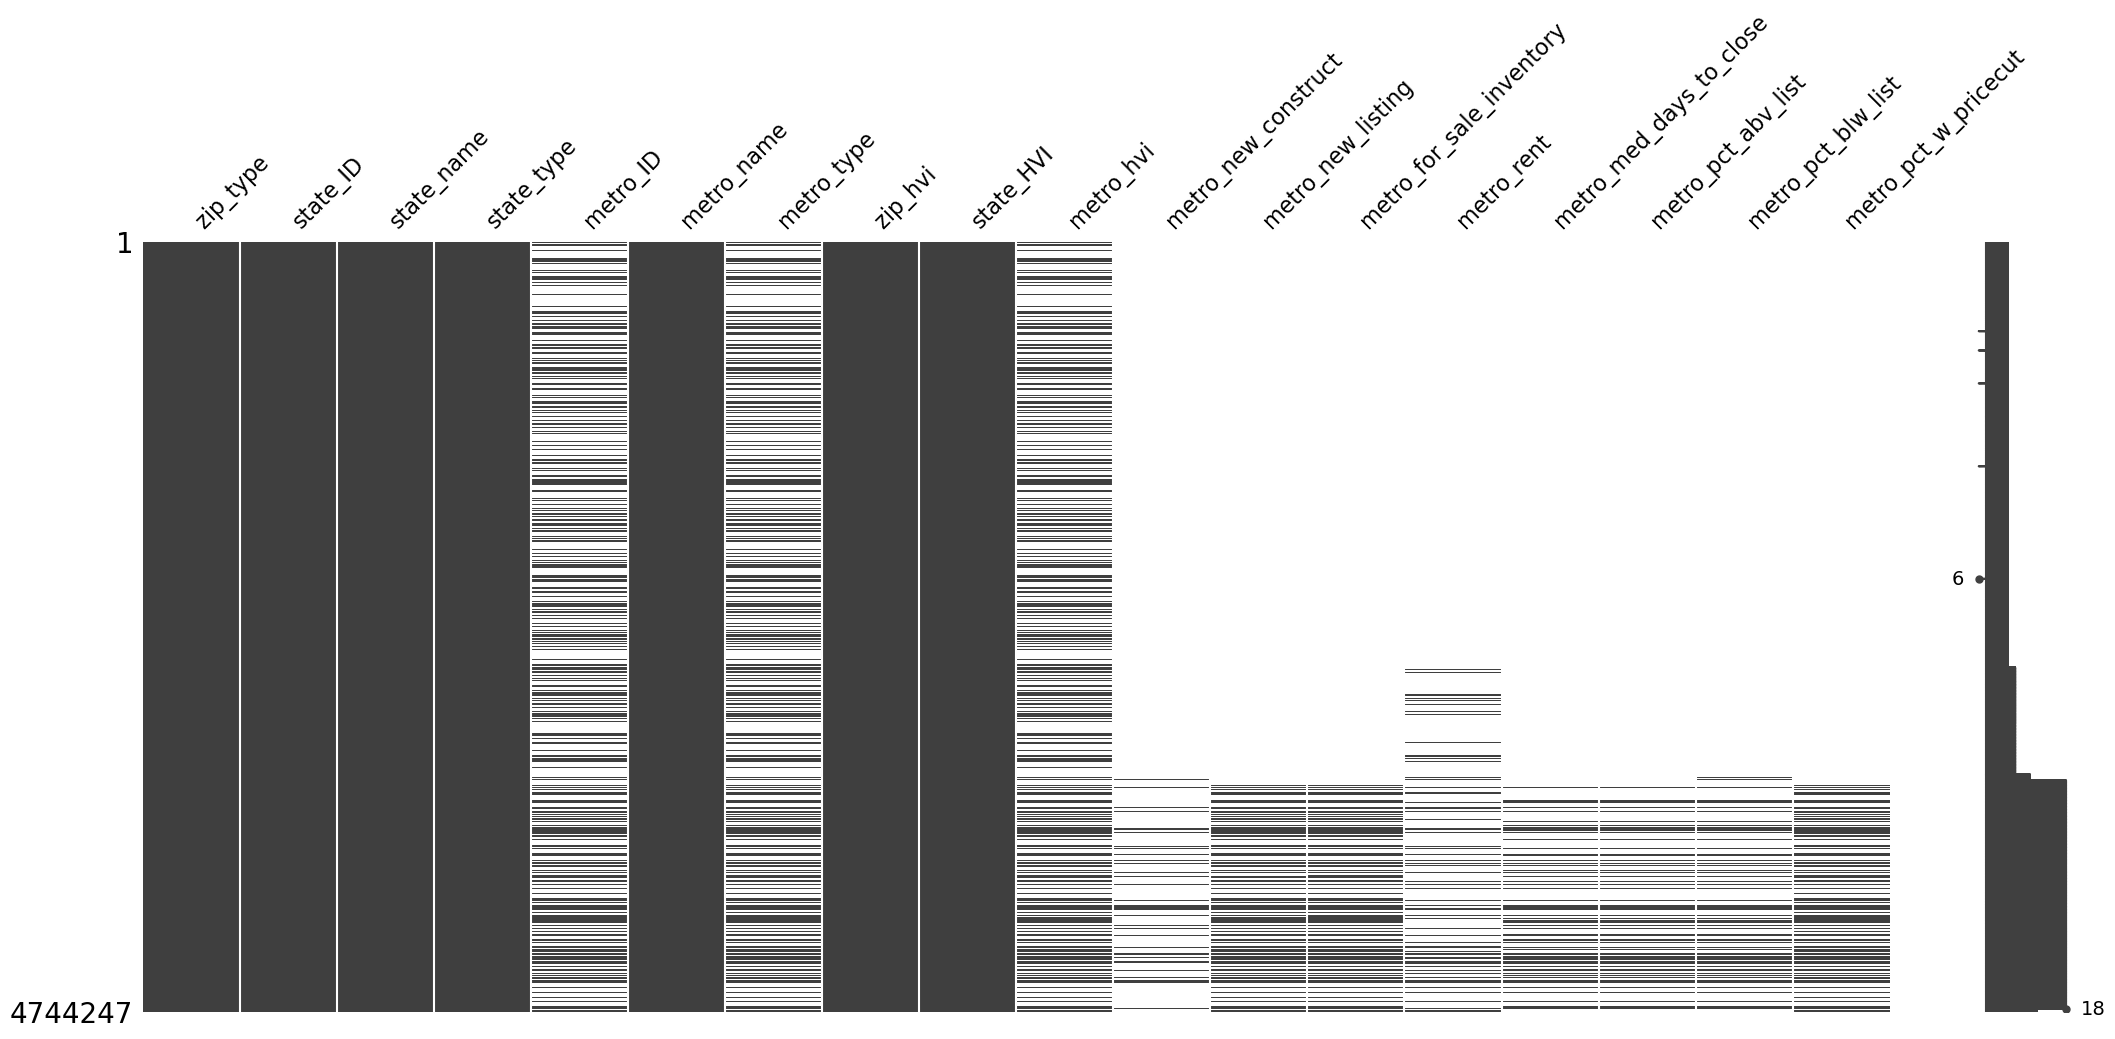

In [58]:
#review missing values
msno.matrix(zillow_metro_state_zip_clean)

<Axes: >

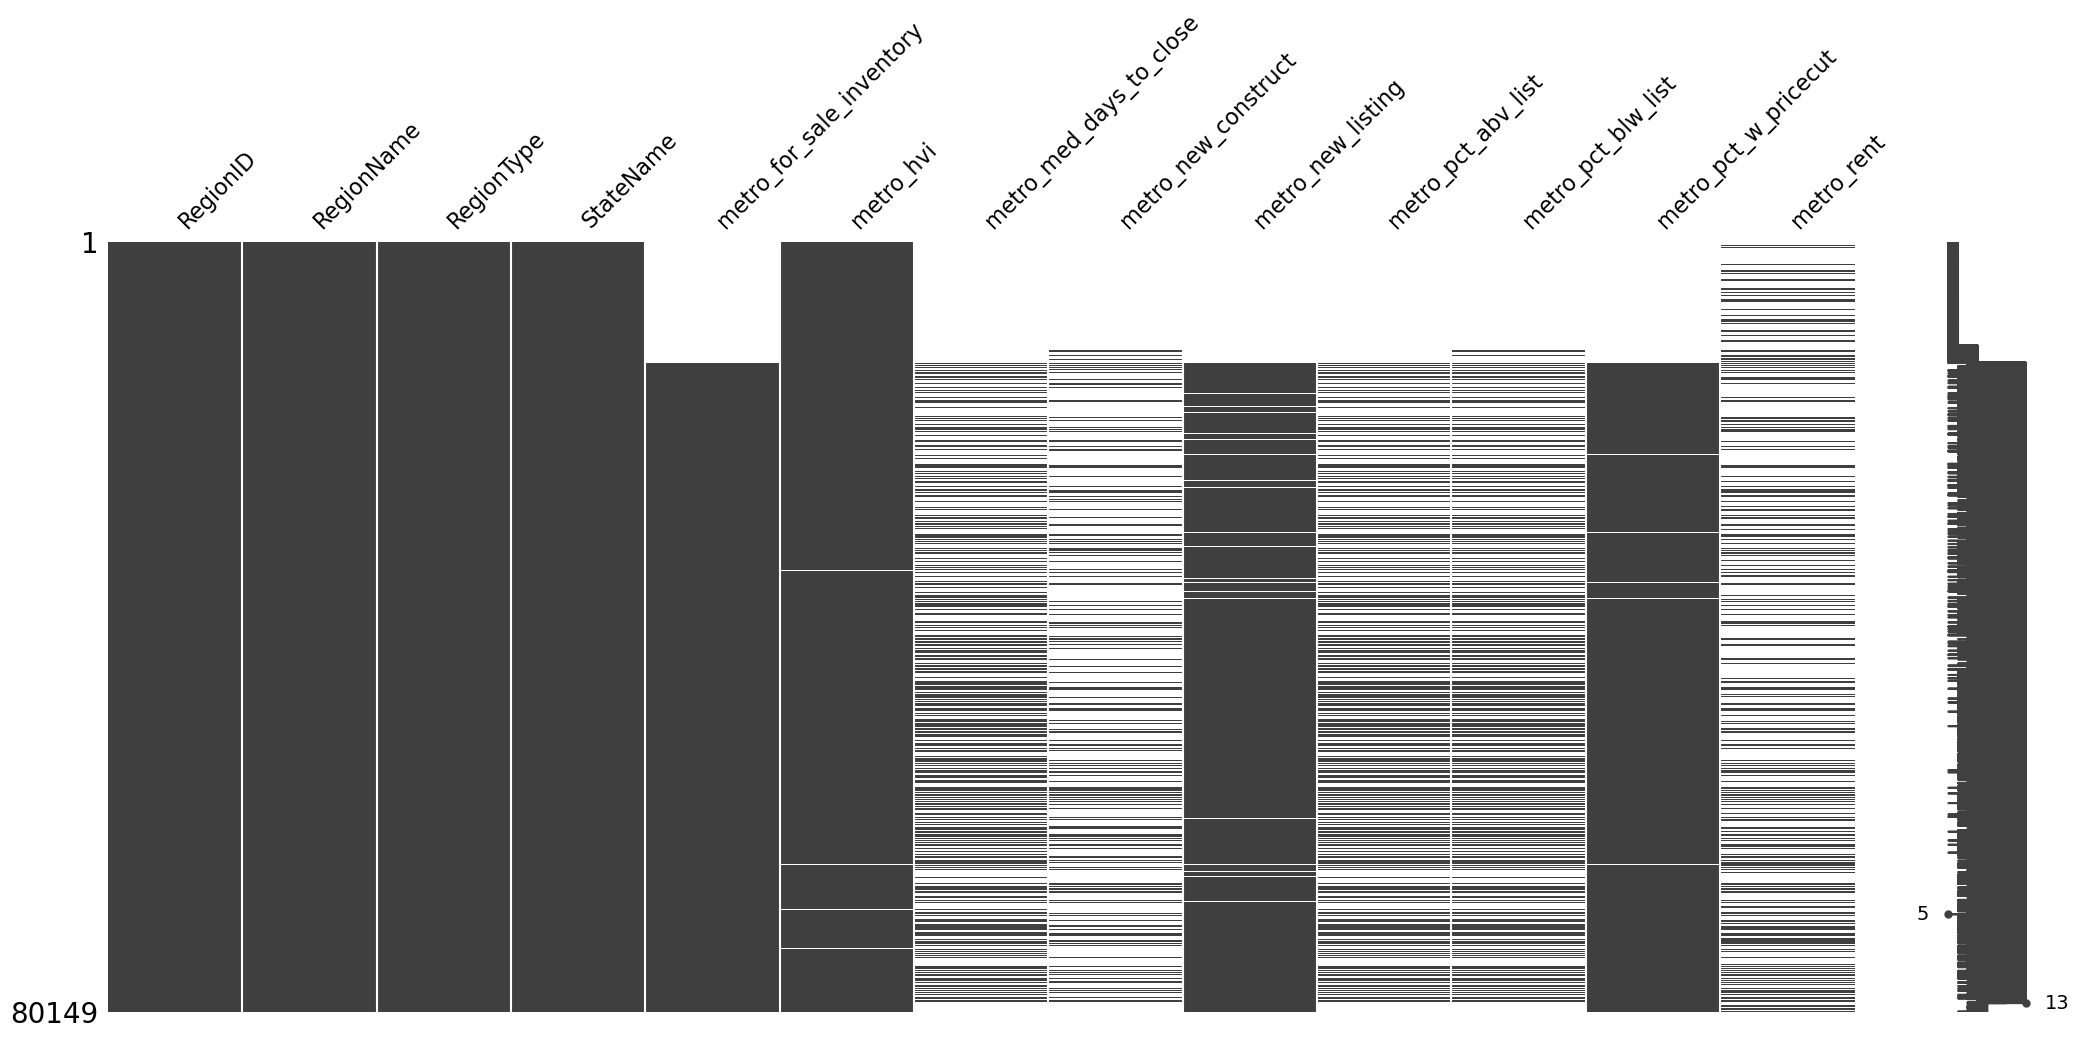

In [64]:
msno.matrix(zillow_metro_df_metrics[zillow_metro_df_metrics.index > '2017-01-01'])

In [ ]:
no_metro = zillow_metro_state_zip_clean['metro_ID'].isna()
no_metro_df = pd.DataFrame(zillow_metro_state_zip_clean[no_metro])
metro_df = pd.DataFrame(zillow_metro_state_zip_clean[~no_metro])

In [ ]:
#review missing values seperately depending if metro data was available for merge
print("No metro")
msno.matrix(no_metro_df)

print("Metro")
msno.matrix(metro_df)

In [ ]:
new_listing_null = metro_df['metro_new_listing'].isnull()
new_listing_df = metro_df[~new_listing_null]
print("New listing min: ",new_listing_df.index.get_level_values('variable').min())
print("New listing max: ",new_listing_df.index.get_level_values('variable').max())

Metro data available for more recent years only. Intermiten availability for most fields.
Metro_HVI is consistently available.
Metro_new_listing, metro_for_sale_inventory and metro_pct_w_pricecut appear to be most consistently available beginning March 2018.

**Review missing metro areas and apply fuzzy match where possible**

In [ ]:
#Look at one zip code as an example
ATX = zillow_metro_state_zip_clean.xs('78704', level='zip_ID')
ATX.head()

In [ ]:
#Austin-Round Rock-Georgetown, TX appears to be slightly different than Austin, TX. Fuzzy match needed.
TX = zillow_metro_df_metrics[zillow_metro_df_metrics['StateName'] == "TX"]
TX['RegionName'].unique()

In [ ]:
unmatched_metros = list(no_metro_df['metro_name'].unique()) #List of unmatched metros from zip code data
metro_list = list(zillow_metro_df_metrics['RegionName'].unique()) #Unique list of metros from metro data

In [ ]:
#Create dictionary with best match for each unmatched metro
matches = {}

for metro in unmatched_metros:
    best_match, score = process.extractOne(metro, metro_list)
    matches[metro] = (best_match, score)
    
print(matches)

In [ ]:
fuzzy_metro_df = pd.DataFrame(matches).T
filt = fuzzy_metro_df[1] > 86
copy = fuzzy_metro_df[filt].sort_values(by = 1)
copy.head(20)
#Scores greater than 86 appear to be a true match

In [ ]:
#Create dictionary with best match for each unmatched metro
matches_filtered = {}

for key, value in matches.items():
    if value[1] > 86:
        matches_filtered[key] = value
    
print(matches_filtered)

In [ ]:
no_metro_df

In [ ]:
#Add fuzzy match to dataframe
fuzzy_metro_name = {k:v[0] for k, v in matches_filtered.items()}
fuzzy_score = {k:v[1] for k, v in matches_filtered.items()}

no_metro_df['fuzzy_metro_name'] = no_metro_df['metro_name'].map(fuzzy_metro_name)
no_metro_df['fuzzy_score'] = no_metro_df['metro_name'].map(fuzzy_score)

In [ ]:
#Replace metro name with fuzzy name
print(no_metro_df.shape)
no_metro_df_temp1 = no_metro_df

print(no_metro_df_temp1['fuzzy_metro_name'].isnull().sum())
no_fuzzy_match = no_metro_df_temp1['fuzzy_metro_name'].isnull() 
no_metro_df_temp1.loc[no_fuzzy_match, 'fuzzy_metro_name'] = no_metro_df_temp1.loc[no_fuzzy_match, 'metro_name']
print(no_metro_df_temp1['fuzzy_metro_name'].isnull().sum())

#Update column names
no_metro_df_temp1 = no_metro_df.reset_index()
no_metro_df_temp1.drop(columns=['metro_name'], inplace=True)
no_metro_df_temp1.rename(columns={'fuzzy_metro_name':'metro_name'}, inplace=True)

print(no_metro_df_temp1.shape)
no_metro_df_temp1.head()

In [ ]:
#Remerge metro dataset with fuzzy metro name
no_metro_df_temp = pd.merge(
    no_metro_df_temp1[['variable','zip_ID','zip_type', 'state_ID', 'state_name', 'state_type', #exclude metro metrics from no_metro_df
       'metro_ID', 'metro_name', 'metro_type', 'zip_hvi',
       'state_HVI', 'fuzzy_score']],
    zillow_metro_df_metrics,
    left_on=['metro_name','variable'],right_on=['RegionName','variable'],how='inner')

no_metro_df_updated = no_metro_df_temp.drop(columns=['metro_ID','metro_name','metro_type','StateName'])
no_metro_df_updated = no_metro_df_updated.rename(columns={
    "RegionID":"metro_ID",
    "RegionName":"metro_name",
    "RegionType":"metro_type"
})

print(no_metro_df_updated['fuzzy_score'].unique())
print(no_metro_df_updated.shape)
no_metro_df_updated.head()

In [ ]:
#Identify records from no_metro_df that have been dropped
unmatched_index_left = no_metro_df_temp1.index.difference(no_metro_df_updated.index)
no_metro_df_no_update = no_metro_df_temp1.loc[unmatched_index_left]
no_metro_df_no_update.shape
print(len(unmatched_index_left))
print(len(no_metro_df_updated))
print(len(no_metro_df))

In [ ]:
metro_df = metro_df.reset_index()
no_metro_df_updated = no_metro_df_updated.reset_index()
no_metro_df_no_update = no_metro_df_no_update.reset_index()

In [ ]:
zillow_zip_data = pd.concat([metro_df, no_metro_df_updated, no_metro_df_no_update], ignore_index=True)
zillow_zip_data = zillow_zip_data.set_index('variable')
zillow_zip_data.head()

In [ ]:
print("Updated Zillow dataframe includes same record count: ",len(zillow_zip_data) == len(zillow_metro_state_zip_clean))

*****
**Review data sample and save**
*****

In [ ]:
#Review metro hvi for 8 metros in Texas
z_TX = zillow_zip_data[zillow_zip_data['state_ID'] == 'TX'].reset_index()
z_TX_metros = z_TX['metro_name'].unique()
first8 = z_TX_metros[:8]
z_TX_first8 = z_TX[z_TX['metro_name'].isin(first8)]
sns.lineplot(x='variable', y='metro_hvi', hue='metro_name', data=z_TX_first8)
plt.show()

In [ ]:
zillow_zip_data.T

In [ ]:
zillow_zip_data.rename(columns={"state_HVI":"state_hvi"},inplace=True)

In [ ]:
zillow_metro_state_clean.T

In [ ]:
zillow_state_df_metrics.T

In [ ]:
zillow_zip_data.to_pickle('../Data/zillow_zip_data.pkl')
zillow_metro_state_clean.to_pickle('../Data/zillow_metro_data.pkl')
zillow_state_df_metrics.to_pickle('../Data/zillow_state_data.pkl')